# Power Plant Hedging Simulation

This notebook simulates a power plant’s operations, calculates hedging strategies, and analyzes PnL (Profit and Loss). The workflow includes:

1. Setting up the environment and simulation parameters.
2. Initializing forward curves and spread models.
3. Running the power plant simulation.
4. Executing the minimum variance hedging strategy.
5. Calculating and plotting the PnL.

---



In [2]:
import pandas as pd
import os

from forward_curve.forward_curve import generate_yearly_seasonal_curve, ForwardCurve
from hedging.min_var_hedge import MinVarHedge
from pnl.ops_plot_hedge_pnl import OpsPlotPnL
from market_simulation.spread_model.spread_model import SpreadModel
from pnl.hedge_pnl import HedgePnL
from valuation.operations_states import OperationalState
from valuation.power_plant.power_plant import PowerPlant
from base_config import CONFIG_FOLDER_ENV


# Set the environment variable for this notebook session
os.environ[CONFIG_FOLDER_ENV] = "C:\Projects\power-plant-rl\config"

## 1. Simulation Configuration
Set up the simulation period, number of Monte Carlo simulations, and paths for configuration files.

In [4]:
# Simulation configuration
config_path_spread_model = "model_configs/spread_model.json"
as_of_date = pd.Timestamp("2025-09-30")

simulation_start = as_of_date
simulation_end = pd.Timestamp("2026-12-31")
simulation_days = pd.date_range(start=simulation_start, end=simulation_end, freq="D")

n_sims = 1000

## 2. Initialize Forward Curves and Spread Model
We generate forward curves for power and coal and initialize the spread model.

In [5]:
# Generate initial forward curves
power_fwd_0 = generate_yearly_seasonal_curve(
    as_of_date=as_of_date,
    start_date=simulation_start,
    end_date=simulation_end,
    winter_value=130,
    summer_value=40.0,
)

coal_fwd_0 = ForwardCurve.generate_curve(
    as_of_date=as_of_date,
    start_date=simulation_start,
    end_date=simulation_end,
    start_value=90,
    end_value=80.0,
    name="Coal Forward Curve",
)

# Initialize spread model
spread_model = SpreadModel(as_of_date, simulation_days, config_path=config_path_spread_model)

# Simulate spot and forward prices
power_fwd, power_month_ahead, power_spot, coal_fwd, coal_month_ahead, coal_spot = spread_model.simulate(
    power_fwd_0=power_fwd_0, coal_fwd_0=coal_fwd_0, n_sims=n_sims, use_cache=True
)

[CACHE] Loaded cached simulation from C:\Users\danie\AppData\Local\Temp\bcfdd519a2941b578f52a5912474c46e
[CACHE] Loaded cached simulation from C:\Users\danie\AppData\Local\Temp\e2718287890922794797f41764d65781


## 3. Initialize and Optimize the Power Plant
Set up the PowerPlant object and run its optimization.

In [7]:
# Power plant simulation period
asset_start = pd.Timestamp(2025, 10, 1)
asset_end = asset_start + pd.Timedelta(days=364)
asset_days = pd.date_range(start=asset_start, end=asset_end, freq="D")

# Initial operational state
initial_state = OperationalState.IDLE

# Initialize PowerPlant
power_plant = PowerPlant(
    n_sims=n_sims,
    asset_days=asset_days,
    initial_state=initial_state,
    spots_power=power_spot,
    spots_coal=coal_spot,
    fwds_power=power_fwd,
    fwds_coal=coal_fwd,
    fwd_0_power=power_fwd_0,
    fwd_0_coal=coal_fwd_0,
    config_path="asset_configs/power_plant_config.yaml",
)

# Optimize plant operations
power_plant.optimize()

Optimizing simulation days: 100%|██████████| 364/364 [00:49<00:00,  7.37day/s]


## 4. Minimum Variance Hedging
Compute the hedge strategy for the power plant and roll out the cashflows of the hedge.

In [8]:
# Initialize hedging strategy
min_var_hedge = MinVarHedge(
    n_sims=n_sims,
    simulation_days=simulation_days,
    power_plant=power_plant,
    spots_power=power_spot,
    spots_coal=coal_spot,
    fwds_power=power_fwd,
    fwds_coal=coal_fwd,
)

# Execute hedge and calculate cashflows
min_var_hedge.hedge()
min_var_hedge.roll_out_cashflows()

Determine minimal variance hedge: 366day [01:14,  4.94day/s]                        


## 5. Calculate PnL
Compute and visualize the PnL for the hedging strategy.

Calculating PnL: 100%|██████████| 457/457 [00:18<00:00, 25.34day/s] 


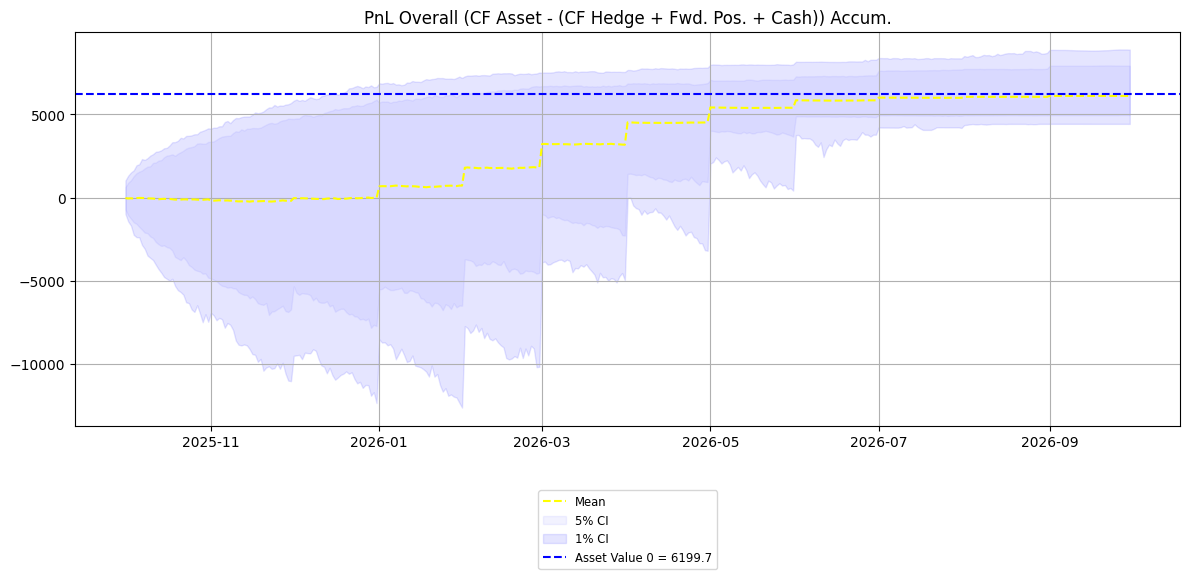

In [9]:
hedge_pnl = HedgePnL(
    n_sims=n_sims,
    simulation_days=simulation_days,
    asset=power_plant,
    hedge=min_var_hedge
)

hedge_pnl.calculate_pnl()

# Plot PnL
ops_plot_pnl = OpsPlotPnL(hedge_pnl)
ops_plot_pnl.plot_pnl()